In [46]:
from FDFD.Fdfd import Fdfd
from nonlinear_solvers import born_solve, newton_solve
from FDFD.linalg import solver_direct

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
omega = 2*np.pi*200e12      # angular frequency (2pi)
dl = 0.02                   # grid size (units of L0, which defaults to 1e-6)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [48]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [49]:
# set source 
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1

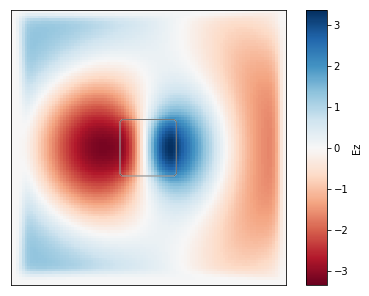

In [50]:
# Solve simulation and plot Ez
simulation = Fdfd(omega,eps_r,dl,NPML,pol)# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_re(outline=True, cbar=True);

In [51]:
# Define objective function and partial derivative
Jregion = np.zeros(eps_r.shape)
Jregion[45:50, 60] = 1
J = lambda Ez: np.sum(np.square(np.abs(Ez*Jregion)))
dJdE = lambda Ez: np.conj(Ez)*Jregion
# Define permittivity change region
deps_region = np.zeros(eps_r.shape)
deps_region[45:50, 40:50] = 1;

In [52]:
# Compute numerical gradient
deps = 1e-8
simulation.reset_eps(eps_r + deps*deps_region)
(Hxf,Hyf,Ezf) = simulation.solve_fields(b)
simulation.reset_eps(eps_r - deps*deps_region)
(Hxb,Hyb,Ezb) = simulation.solve_fields(b)
grad_num = (J(Ezf) - J(Ezb))/2/deps
print(grad_num)

2.450932967690278


In [53]:
# Adjoint computation for the Ez polarization 
# Note: this is already the point-by-point computation! dJdeps has the same size as eps_r 
# and has the derivative with respect to every pixel. 
from adjoint import *
dJdeps = dJdeps_linear(simulation, deps_region, J, dJdE)
print(dJdeps.sum())

2.4509329950016157


In [65]:
# Now let's try Hz polarization
pol = 'Hz'  
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

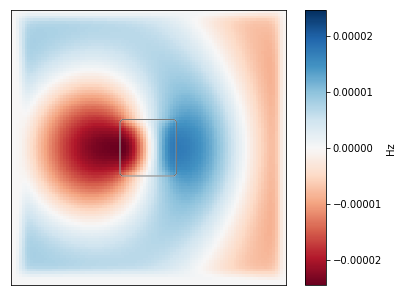

In [66]:
# Solve simulation and plot Hz
simulation = Fdfd(omega,eps_r,dl,NPML,pol)# set source and solve for electromagnetic fields
(Ex,Ey,Hz) = simulation.solve_fields(b)
simulation.plt_re(outline=True, cbar=True);

In [68]:
# Define objective function and partial derivative
Jregion = np.zeros(eps_r.shape)
Jregion[45:50, 50] = 1
J = lambda Hz: np.sum(np.square(np.abs(Hz*Jregion)))
dJdE = lambda Hz: np.conj(Hz)*Jregion
# Define permittivity change region
deps_region = np.zeros(eps_r.shape)
deps_region[45:50, 40:50] = 1;

In [69]:
# Compute numerical gradient
deps = 1e-8
simulation.reset_eps(eps_r + deps*deps_region)
(Exf,Eyf,Hzf) = simulation.solve_fields(b)
simulation.reset_eps(eps_r - deps*deps_region)
(Exb,Eyb,Hzb) = simulation.solve_fields(b)
grad_num = (J(Hzf) - J(Hzb))/2/deps
print(grad_num)

5.797990981973052e-10


In [85]:
# Adjoint computation for the Hz polarization 
# It works! 
from adjoint import *
dJdeps = dJdeps_linear(simulation, deps_region, J, dJdE)
print(dJdeps.sum())

5.797969603736201e-10
